### Import Statements

In [4]:
import requests
import fitz  # PyMuPDF
import contextlib
import re
import torch
import numpy as np
import os
from numpy.typing import ArrayLike

### Model loading

Loading the pytorch version of Gemma 7b Instruct (int8 quantized)

In [5]:
from gemma.config import get_config_for_7b
from gemma.model import GemmaForCausalLM

# Utilizes: 12.7 GB VRAM, ~ 24 GB RAM at peak
def gemma_call(prompt: str):

  VARIANT = "7b-it-quant" 
  MACHINE_TYPE = "cuda" 
  weights_dir = 'gemma/7b-it-quant/' 

  @contextlib.contextmanager
  def _set_default_tensor_type(dtype: torch.dtype):
    """Sets the default torch dtype to the given dtype."""
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(torch.float)

  # Model Config
  model_config = get_config_for_7b() if "7b" in VARIANT else print('Download required.')
  model_config.tokenizer = os.path.join(weights_dir, "tokenizer.model")
  model_config.quant = "quant" in VARIANT

  # Model
  device = torch.device(MACHINE_TYPE)
  with _set_default_tensor_type(model_config.get_dtype()):
    model = GemmaForCausalLM(model_config)
    ckpt_path = os.path.join(weights_dir, f'gemma-7b-quant.ckpt')
    model.load_weights(ckpt_path)
    model = model.to(device).eval()

  USER_CHAT_TEMPLATE = "<start_of_turn>user\n{prompt}<end_of_turn>\n"
  MODEL_CHAT_TEMPLATE = "<start_of_turn>model\n{prompt}<end_of_turn>\n"

  model_input = (
    USER_CHAT_TEMPLATE.format(prompt=prompt)
    + "<start_of_turn>model\nSure here it is:"
  )

  print(model_input)

  answer = model.generate(
      model_input,
      device=device,
      output_len=100, 
      temperature=0.1,
      top_p=0.5, 
      top_k=20, 
  )

  torch.cuda.empty_cache()
  return answer

### Data Retriaval
Download of the pdf file(s)

In [6]:
pdf_url = "https://bugs.python.org/file47781/Tutorial_EDIT.pdf"

def download_pdf(url):
    response = requests.get(url)
    with open('temp.pdf', 'wb') as f:
        f.write(response.content)
    return 'temp.pdf'

def pdf_to_text(filename):
    doc = fitz.open(filename)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

def clean_text(text):
    # Remove double spaces
    return re.sub(' +', ' ', text)

def split_text_into_chunks(text, num_chunks):
    words = text.split()
    total_words = len(words)
    chunk_size = total_words // num_chunks
    chunks = [' '.join(words[i * chunk_size : (i + 1) * chunk_size]) for i in range(num_chunks)]
    return chunks

pdf_file = download_pdf(pdf_url)
pdf_text = pdf_to_text(pdf_file)
clean_pdf_text = clean_text(pdf_text)

# Decide on the number of chunks you want
num_chunks = 7
chunks = split_text_into_chunks(clean_pdf_text, num_chunks)

# This will print the chunks, you can process them further as needed
for i, chunk in enumerate(chunks, 1):
    print(f"Chunk {i}: {chunk[:100]}...")  # Printing the first 100 characters of each chunk for brevity


Chunk 1: Python Tutorial Release 3.7.0 Guido van Rossum and the Python development team September 02, 2018 Py...
Chunk 2: The old formatting operations invoked when strings are the left operand of the % operator are descri...
Chunk 3: >>> a ^ b # letters in a or b but not both {'r', 'd', 'b', 'm', 'z', 'l'} Similarly to list comprehe...
Chunk 4: types like nested lists and dictionaries, parsing and serializing by hand becomes complicated. Rathe...
Chunk 5: in [1, 2, 3]: print(element) for element in (1, 2, 3): print(element) for key in {'one':1, 'two':2}:...
Chunk 6: given above, the best 754 double approximation it can get: >>> 0.1 * 2 ** 55 3602879701896397.0 If w...
Chunk 7: are useful to static type analysis tools, and aid IDEs with code completion and refactoring. Type hi...


### Data Cleaning
Using the 7B instruct model

### Embedding Function
for ChromaDB

In [19]:
import chromadb as db  # This helps us work with the vectors database
from chromadb.utils import embedding_functions  # This helps us fetch our embedding model
from chromadb import Documents, EmbeddingFunction, Embeddings
from sentence_transformers.util import cos_sim, dot_score

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import string

class Embedding(EmbeddingFunction):
    def __init__(self):
        self.embedding_model = embedding_functions.SentenceTransformerEmbeddingFunction('thenlper/gte-large')  # ("Salesforce/SFR-Embedding-Mistral") (7b)

    def encode(self, input: Documents) -> Embeddings:
        embeddings = self.embedding_model(input)
        return embeddings

    def distance(self, x: ArrayLike, y: ArrayLike) -> float:
        return cos_sim(x, y)

    def plot(self, query: str, documents: Documents) -> None:
        query = query[0] if isinstance(query, list) and len(query) == 1 else query
        texts = [query] + documents if query else documents
        embeddings = self.encode(texts)
        tsne_results = TSNE(n_components=2, perplexity=min(30, len(embeddings) - 1)).fit_transform(np.array(embeddings))
        cluster_labels = DBSCAN(eps=0.9, min_samples=2).fit(tsne_results[1:]).labels_ if query else DBSCAN(eps=0.5, min_samples=2).fit(tsne_results).labels_

        plt.figure(figsize=(12, 8))
        plt.axis('off')
        if query:
            plt.scatter(tsne_results[0, 0], tsne_results[0, 1], c='red', label='Query', s=100)
            plt.annotate(query, (tsne_results[0, 0], tsne_results[0, 1]), fontsize=9, alpha=0.7, color='black')

        scatter = plt.scatter(tsne_results[1:, 0], tsne_results[1:, 1], c=cluster_labels, cmap='Pastel2', alpha=0.85)

        FILLER_WORDS = set([
            'the', 'and', 'a', 'to', 'of', 'in', 'i', 'is', 'that', 'on', 
            'for', 'it', 'with', 'as', 'this', 'by', 'are', 'be', 'was', 'or', 'you', 'an',
        ])

        # Find and annotate clusters with frequent words
        for label in set(cluster_labels):
            if label == -1:  # Ignore noise
                continue
            cluster_docs = [documents[i] for i, lbl in enumerate(cluster_labels) if lbl == label]
            words = ' '.join(cluster_docs).lower().split()
            words = [word.strip(string.punctuation) for word in words if word not in FILLER_WORDS and word.strip(string.punctuation) not in FILLER_WORDS]
            word_counts = Counter(words)
            most_common_words = ' '.join(word for word, count in word_counts.most_common(3))  # Get top 3 words

            cluster_center = np.mean([tsne_results[i + 1] for i, lbl in enumerate(cluster_labels) if lbl == label], axis=0)
            plt.annotate(most_common_words, (cluster_center[0], cluster_center[1]), fontsize=9, alpha=0.7, color='black')

        plt.grid(True, which='both', linestyle='--', linewidth=0.2)
        plt.show()

In [20]:
model = Embedding()

print(model.distance(model.encode(['Coffee', 'Water']), model.encode(['Espresso'])))

tensor([[0.8790],
        [0.7856]])


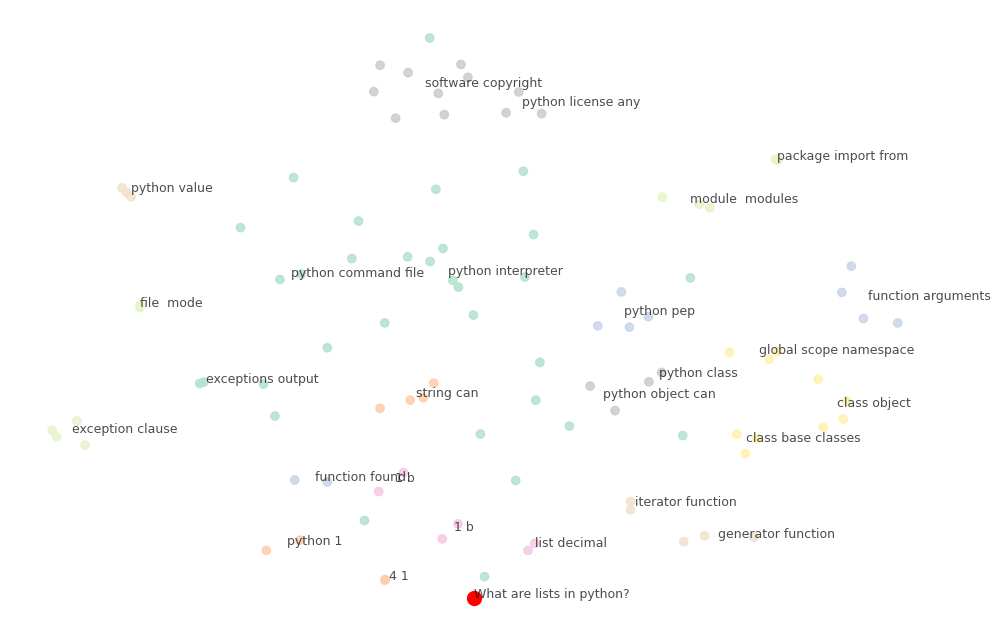

In [21]:
model.plot(['What are lists in python?'], split_text_into_chunks(clean_pdf_text, 100))

In [68]:
print(gemma_call('Please use 3 words to describe the following paragarph:\n\n' + ''.join(i for i in split_text_into_chunks(clean_pdf_text, 250)[40:41])+ '\n'))

<start_of_turn>user
Please use 3 words to describe the following paragarph:

writing the expression you want to write (as we did earlier in the calculator examples) in the way it handles multiple arguments, ﬂoating point quantities, and strings. Strings are printed without quotes, and a space is inserted between items, so you can format things nicely, like this: 16 Chapter 3. An Informal Introduction to Python Python Tutorial, Release 3.7.0 >>> i = 256*256 >>> print('The value of i is', i) The value of i is 65536 The keyword argument end can be used to avoid the newline after the output, or end the output with a diﬀerent string: >>> a, b = 0, 1 >>> while a < 1000: ... print(a, end=',') ... a, b = b, a+b ... 0,1,1,2,3,5,8,13,21,34,55,89,144,233,377,610,987, 3.2. First Steps Towards Programming 17 Python Tutorial, Release 3.7.0 18 Chapter 3. An Informal Introduction to Python CHAPTER FOUR MORE CONTROL FLOW TOOLS Besides the while statement just introduced, Python knows the usual control 

### Data Loading
Loading the data into ChromaDB

In [ ]:
import sqlite3
def __split_string_in_half(self, s):
    # Split the string into words
    words = s.split()
    
    # Find the midpoint of the list of words
    mid_index = len(words) // 2

    for i in rnage()
    
    # Adjust the midpoint for even division; you can modify this as needed
    if len(words) % 2 != 0:  # Check if the number of words is odd
        mid_index += 1  # Adjust so the first half gets the extra word
    
    # Split the list into two halves
    first_half_words = words[:mid_index]
    second_half_words = words[mid_index:]
    
    # Rejoin each half into a string
    first_half = ' '.join(first_half_words)
    second_half = ' '.join(second_half_words)
    
    return first_half, second_half

collection_exists = "Green-AI" in [collection.name for collection in self.client.list_collections()]
if not collection_exists:
    con = sqlite3.connect("crawler/mitteilungen.db")
    cur = con.cursor()
    
    mitteilungen = cur.execute("SELECT * FROM mitteilungen").fetchall()

    con = sqlite3.connect("crawler/green-ai-projekte-eng.db")
    cur = con.cursor()
    projekte = cur.execute("SELECT * FROM projekte").fetchall()

    collection = self.client.create_collection(
        name=f"Green-AI",
        metadata={"hnsw:space": "cosine"}, # l2 is the default
        embedding_function=self.embedding_model,
    )
    documents = []
    metadata = []
    ids = []
    # for mitteilung in mitteilungen:
    #     documents.append(mitteilung[2])
    #     metadata.append({"title": mitteilung[1]})
    #     ids.append("mitteilung " + str(mitteilung[0]))
    for projekt in projekte:
        document_text = projekt[2].replace("\t", " ")
        document_text = document_text.replace("\n", " ")
        document_text = document_text.replace("  ", " ")
        for i, current_text in enumerate(self.__split_string_in_half(document_text)):
            documents.append(current_text)
            metadata.append({"title": projekt[1]})
            ids.append(f"projekt_{str(projekt[0])}_{i}")
    collection.add(
        documents=documents,
        metadatas=metadata,
        ids=ids,
    )

### RAG Class
Document retrieval and prompt engineering

In [ ]:
import chromadb
from chromadb.utils import embedding_functions # This helps us fetch our embedding model
from mlx_lm import load, generate

class RAG:

    def __init__(self, translator) -> None:
        self.embedding_model = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="intfloat/multilingual-e5-large")
        self.client = chromadb.PersistentClient(path="./chromadb")
        self.__init_database()
        self.collection = self.client.get_or_create_collection(
            name=f"Green-AI",
            metadata={"hnsw:space": "cosine"},
            embedding_function=self.embedding_model,
        )
        self.model, self.tokenizer = load("mlx-community/Mistral-7B-Instruct-v0.2-4bit-mlx")
        self.translator = translator

    def query(self, prompt):
        return self.collection.query(query_texts=prompt, n_results=1)

    def generate_text(self, prompt: str, tasks: dict, task_id: str) -> str:
        print("Started the RAG generation")
        translated_text = self.translator.translate_text(prompt, target_lang="EN-US")
        result = self.collection.query(
            query_texts=translated_text.text,
            n_results=1,
        )
        documents = result["documents"][0][0]
        prompt = f"<s>[INST] You are a assistant. Answer the following question based on the attached text. Text: {documents}\n Question: {translated_text.text}[/INST] "
        output = generate(self.model, self.tokenizer, prompt=prompt, verbose=False, max_tokens=1000, repetition_penalty=1.1)
        print(output)
        translated_output = self.translator.translate_text(output, target_lang=translated_text.detected_source_lang)
        tasks[task_id]["result"] = translated_output.text

### LLM Generating Answers
Including a Chat Interface